# 011. PyTorch Dataset

### Dataset 클래스

 - PyTorch는 두 개의 데이터 관련 클라스를 제공하여 pre-loaded datasets 및 custom dataset 을 사용할 수 있도록 한다.
 
     - torch.utils.data.Dataset - 샘플 및 해당 레이블을 제공
     - torch.utils.data.DataLoader - 샘플에 쉽게 액세스 할 수 있도록 Dataset의 iterable 을 wrapping
     

- PyTorch domain library (Image, Text, Audio dataset) 들은 torch.utils.data.Dataset 을 상속 받은 pre-loaded dataset (ex. FashionMNIST)과 관련 함수 제공
 

- torch.utils.data.Dataset 은 데이터셋을 나타내는 추상클래스이다.


- custom 데이터셋은 Dataset 을 상속하고 아래와 같이 Dataset method 를 오버라이드 하여 작성


    - 생성자 __init__ 은 dataset 의 전처리를 해주는 부분
    - len(dataset) 에서 호출되는 __len__ 은 데이터셋의 크기를 리턴
    - dataset[i] 에서 호출되는 __getitem__ 은 𝑖 번째 샘플을 찾는데 사용

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

## 사용자 정의 Dataset 작성

- 특정 길이의 data를 생성하는 사용자 정의 Dataset class  
- transform object를 전달 받으면 data 변환을 하여 반환  
- iterable형태로 사용

In [13]:
class toy_set(Dataset):
    def __init__(self, length=10, transform=None):
        torch.manual_seed(101)
        self.x = 10 * torch.ones(length, 2)
        self.y = torch.ones(length, 1)
        self.len = length
        self.transform = transform
    def __getitem__(self, idx):
        sample = self.x[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    def __len__(self):
        return self.len

### iterable 형태로 사용
- len(dataset)  
- dataset[ i ]

In [14]:
test_data = toy_set()
len(test_data)

10

In [15]:
for i in range(3):
    x, y = test_data[i]
    print(x, y)

tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])


In [16]:
for x, y in test_data:
    print(x, y)

tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])


In [17]:
next(iter(test_data))

(tensor([10., 10.]), tensor([1.]))

## Transform 적용

- 사용자 정의 transform module 을 Custom Dataset 에 적용

### Transform 함수 적용 예 : scaling

In [22]:
def scaling(sample):
    x, y = sample
    scaled_x = x / 100000
    scaled_y = y / 10
    return scaled_x, scaled_y

In [26]:
dataset_ = toy_set(3, scaling)

dataset_[-1]

(tensor([1.0000e-04, 1.0000e-04]), tensor([0.1000]))

### transform class 적용 예

In [27]:
class add_ones:
    def __init__(self, added=1):
        self.added = added
        
    def __call__(self, sample):
        x, y = sample
        x = x + self.added
        y = y + self.added
        sample = x, y
        return sample

In [31]:
a_m = add_ones()

dataset_ = toy_set(10, transform=a_m)
dataset_[-1]

(tensor([11., 11.]), tensor([2.]))

### Transform 을 동시에 여러개 적용 : transform.Compose 

In [38]:
from torchvision import transforms
data_transforms = transforms.Compose([scaling, a_m])

data2 = toy_set(5, transform=data_transforms)

In [39]:
#data2 = toy_set(5)
for x, y in data2:
    print(x, y)

tensor([1.0001, 1.0001]) tensor([1.1000])
tensor([1.0001, 1.0001]) tensor([1.1000])
tensor([1.0001, 1.0001]) tensor([1.1000])
tensor([1.0001, 1.0001]) tensor([1.1000])
tensor([1.0001, 1.0001]) tensor([1.1000])


<h1>pre-built Datasets and Transforms</h1> 

In [40]:
from torchvision import datasets

In [43]:
crop_tensor_transform = transforms.Compose(
        [transforms.CenterCrop(20),
        transforms.ToTensor()]
)

training_data = datasets.MNIST(
    root = 'data',
    train=True,
    download=True,
    transform=crop_tensor_transform
)

test_data = datasets.MNIST(
    root = 'data',
    train=False,
    transform=crop_tensor_transform
)

In [57]:
training_data[0][0].shape

torch.Size([1, 20, 20])

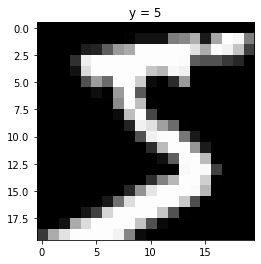

In [59]:
import matplotlib.pyplot as plt
plt.imshow(training_data[0][0].reshape(20, 20), cmap="gray")
plt.title("y = {}".format(training_data[0][1]))
plt.show()

## DataLoader를 사용하여 training 데이터 준비

Dataset은 `한 번에 한 개씩 샘플`의 feature 와 label 을 retreive 합니다. 모델을 훈련하는 동안 일반적으로 `minibatch`로 샘플을 전달하고, 매 epoch 마다 데이터를 reshuffle 하여 overfitting을 줄이며, Python의 multiprocessing을 사용하여 읽는 속도를 높입니다.

DataLoader는 쉬운 API로 이러한 복잡성 내용을 추상화한 반복자(iterable) 입니다.

In [60]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## DataLoader를 통해 반복
해당 데이터 세트를 ``Dataloader``에 로드 했으며 반복할 수 있습니다. 아래의 각 반복은`` train_features`` 및 ``train_labels`` ( batch_size=64 의 feature 및 label) 의 배치를 반환합니다.  ``shuffle=True``를 지정했기 때문에 모든 배치를 반복한 후에 데이터가 섞입니다.

In [62]:
train_features, train_labels = next(iter(train_dataloader))
train_features.size(), train_labels.size()

(torch.Size([64, 1, 20, 20]), torch.Size([64]))

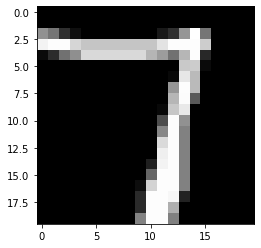

In [67]:
img = train_features[0].squeeze()
plt.imshow(img, cmap="gray")

## TensorDataset
- PyTorch의 TensorDataset은 tensor를 감싸는 Dataset입니다.
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓는 컨테이너입니다.
- TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부분만 간단히 추출할 수 있게 됩니다.  
- TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없으니 주의
- Dataset은 직접 작성할 수도 있어서 대량의 이미지 파일을 한 번에 메모리에 저장하지 않고 필요할 때마다 읽어서 학습하는 등 다양하게 활용 가능

In [74]:
from torch.utils.data import TensorDataset

x = np.random.randn(5, 4)
y = np.random.randint(0, 2, size=5)

X_train = torch.from_numpy(x)
y_train = torch.from_numpy(y)
X_train, y_train

(tensor([[ 0.7620,  1.3676, -0.8925, -0.6012],
         [-0.1406,  0.4350,  0.4254,  0.2158],
         [ 0.3394, -0.3691,  1.1529,  0.4924],
         [-0.3265, -1.1704, -0.8616,  0.4852],
         [-1.2183, -0.2174, -0.4333,  0.7275]], dtype=torch.float64),
 tensor([0, 1, 1, 0, 0], dtype=torch.int32))

In [75]:
train_ds = TensorDataset(X_train, y_train)

train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=False)
train_features, train_labels = next(iter(train_dataloader))
train_features, train_labels

(tensor([[ 0.7620,  1.3676, -0.8925, -0.6012],
         [-0.1406,  0.4350,  0.4254,  0.2158]], dtype=torch.float64),
 tensor([0, 1], dtype=torch.int32))